<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#High-confidence-errors" data-toc-modified-id="High-confidence-errors-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>High confidence errors</a></span></li></ul></div>

In [232]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
import pandas as pd
import numpy as np
from librosa.core import resample, load
from librosa.util import fix_length
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, auc
)
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import IPython

In [14]:
data = pd.read_csv('clean.csv')

In [21]:
all_classes = [c for c in data.columns if c.startswith('class')]
class_count = data[all_classes].idxmax(axis=1).value_counts()
class_count

class_Snare        2166
class_Kick         1556
class_Hat          1289
class_Tom          1268
class_Cymbal        722
class_Clap          307
class_Cowbell       152
class_Conga         120
class_Shaken        104
class_Tambourin      75
class_Bongo          60
class_Agogo          56
class_Clave          54
class_Timbales       49
class_Djembe         20
class_Guiro          19
class_Cajon          12
class_Cuica          10
class_Timpani        10
class_Tabla           9
class_Triangle        8
class_Gong            4
class_Darbuka         4
class_clave           2
dtype: int64

In [22]:
classes_cols = class_count[class_count > 100].index

In [23]:
nb_classes = len(classes_cols)
data = data[data[classes_cols].sum(axis=1) == 1]

In [24]:
data.shape

(7684, 45)

In [25]:
data.head()

,path,filename,dir_1,class_Hat,subclass_Hat_Open,subclass_Hat_Close,class_Bongo,class_Cymbal,subclass_Cymbal_Crash,subclass_Cymbal_Ride,...,subclass_Shaken_Maracas,class_Cajon,class_clave,dir_2,subclass_Snare_Off,subclass_Snare_On,subclass_Snare_Side,subclass_Snare_Flam,subclass_Snare_Brush,subclass_Cymbal_Trash
0,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 OPHAT2.wav,Yamaha RX-11,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD3.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD2.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 CLHAT2.wav,Yamaha RX-11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 RIDE.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
data = data.loc[data['path'] != './Samples/200-drum-machines/Roland JV 1080/MaxV - Guiro.wav']

In [27]:
vggish = hub.load('https://tfhub.dev/google/vggish/1')
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

In [31]:
SR=16000
classes = data[classes_cols]
files = data['path']
vgg_embeddings = []
yam_embeddings = []
for path in tqdm(files):
    sound, _ = load(path, sr=SR)
    sound = fix_length(sound, 1*SR)
    vgg_embeddings.append(vggish(sound))
    _, yam_emb, _ = yamnet(sound)
    yam_embeddings.append(yam_emb[0])

vgg_embeddings = np.stack(vgg_embeddings)
yam_embeddings = np.stack(yam_embeddings)

<ipython-input-31-131a48f41366>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for path in tqdm_notebook(files):


In [32]:
vgg_embeddings.shape, yam_embeddings.shape

((7684, 1, 128), (7684, 1024))

In [33]:
vgg_embeddings = vgg_embeddings.reshape(-1, 128)
yam_embeddings = yam_embeddings.reshape(-1, 1024)

In [34]:
# x_train, x_valid, y_train, y_valid = train_test_split(sounds, classes, test_size=0.3, stratify=classes)
x_vgg_train, x_vgg_valid, x_yam_train, x_yam_valid, y_train, y_valid = train_test_split(vgg_embeddings, yam_embeddings, classes, test_size=0.3, stratify=classes)

In [35]:
x_vgg_train.shape

(5378, 128)

In [258]:
inputs = Input(shape=(128))
x = Dense(100, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_57 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_31 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_32 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 9)                 459       
Total params: 18,409
Trainable params: 18,409
Non-trainable params: 0
_________________________________________________

In [259]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [260]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_cols,
    y=y_train.idxmax(axis=1))

class_weights = dict(zip(range(nb_classes), class_weights))
class_weights

{0: 0.3941659337437702,
 1: 0.5487195184164881,
 2: 0.6624784429662478,
 3: 0.6729229229229229,
 4: 1.1832783278327832,
 5: 2.779328165374677,
 6: 5.637316561844863,
 7: 7.113756613756614,
 8: 8.185692541856925}

In [261]:
history = model.fit(x_vgg_train, y_train, epochs=100, class_weight=class_weights, validation_data=(x_vgg_valid, y_valid))

Epoch 1/100
169/169 [==============================] - 0s 2ms/step - loss: 1.7506 - accuracy: 0.3131 - val_loss: 1.2973 - val_accuracy: 0.6028
Epoch 2/100
169/169 [==============================] - 0s 1ms/step - loss: 1.1334 - accuracy: 0.5043 - val_loss: 1.0245 - val_accuracy: 0.6427
Epoch 3/100
169/169 [==============================] - 0s 2ms/step - loss: 0.9475 - accuracy: 0.5699 - val_loss: 0.9085 - val_accuracy: 0.6756
Epoch 4/100
169/169 [==============================] - 0s 1ms/step - loss: 0.8629 - accuracy: 0.6019 - val_loss: 0.8441 - val_accuracy: 0.6947
Epoch 5/100
169/169 [==============================] - 0s 2ms/step - loss: 0.8203 - accuracy: 0.6294 - val_loss: 0.7959 - val_accuracy: 0.7103
Epoch 6/100
169/169 [==============================] - 0s 2ms/step - loss: 0.7564 - accuracy: 0.6519 - val_loss: 0.7998 - val_accuracy: 0.7095
Epoch 7/100
169/169 [==============================] - 0s 1ms/step - loss: 0.7042 - accuracy: 0.6608 - val_loss: 0.7879 - val_accuracy: 0.7108

Epoch 58/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3668 - accuracy: 0.8033 - val_loss: 0.5617 - val_accuracy: 0.8053
Epoch 59/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3365 - accuracy: 0.8196 - val_loss: 0.5461 - val_accuracy: 0.8096
Epoch 60/100
169/169 [==============================] - 0s 2ms/step - loss: 0.3658 - accuracy: 0.8115 - val_loss: 0.5422 - val_accuracy: 0.8148
Epoch 61/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3316 - accuracy: 0.8176 - val_loss: 0.5356 - val_accuracy: 0.8105
Epoch 62/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3405 - accuracy: 0.8254 - val_loss: 0.5454 - val_accuracy: 0.8096
Epoch 63/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3322 - accuracy: 0.8245 - val_loss: 0.5396 - val_accuracy: 0.8183
Epoch 64/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3201 - accuracy: 0.8273 - val_loss: 0.5458 - val_accuracy:

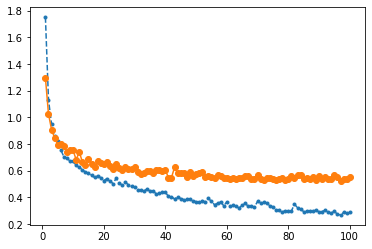

In [262]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [263]:
y_pred = model.predict(x_vgg_valid)
y_pred_class = np.argmax(y_pred,axis=1).astype(int)
y_valid_class = np.argmax(y_valid.values,axis=1).astype(int)

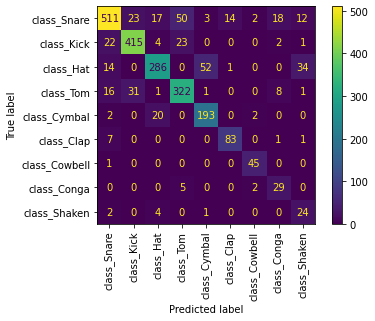

In [264]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_class, y_pred_class),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [265]:
print(classification_report(y_valid_class, y_pred_class, target_names=classes_cols))

               precision    recall  f1-score   support

  class_Snare       0.89      0.79      0.83       650
   class_Kick       0.88      0.89      0.89       467
    class_Hat       0.86      0.74      0.80       387
    class_Tom       0.81      0.85      0.83       380
 class_Cymbal       0.77      0.89      0.83       217
   class_Clap       0.85      0.90      0.87        92
class_Cowbell       0.88      0.98      0.93        46
  class_Conga       0.50      0.81      0.62        36
 class_Shaken       0.33      0.77      0.46        31

     accuracy                           0.83      2306
    macro avg       0.75      0.85      0.78      2306
 weighted avg       0.84      0.83      0.83      2306



In [266]:
roc_auc_score(y_valid_index, model.predict(x_vgg_valid), average='weighted', multi_class='ovr')

0.9694614878335349

### High confidence errors

In [267]:
for i in range(nb_classes):
    for j in range(nb_classes):
        if i == j:
            continue
        true_index = np.where(y_valid_class==i)[0]
        pred_index = np.where(np.argmax(y_pred,axis=1).astype(int) == j)[0]
        index = list(set(true_index.tolist()) & set(pred_index.tolist()))
        if (len(index)==0):
            continue
        confidence = y_pred[index,j]
        index = index[np.argmax(confidence)]
        confidence = y_pred[index,j]
        index = y_valid.iloc[[index]].index
        print(f'true: {classes_cols[i]}')
        print(f'pred: {classes_cols[j]}')
        print(f'confidence: {confidence}')
        path = data.loc[index, 'path'].values[0]
        print(path)
        sound, sr = load(path)
        IPython.display.display(IPython.display.Audio(sound, rate=sr, autoplay=False))

true: class_Snare
pred: class_Kick
confidence: 0.9631442427635193
./Samples/wavegan-drums/train/Snare_02087.wav


true: class_Snare
pred: class_Hat
confidence: 0.9996504783630371
./Samples/musicradar-essential-drumkit-samples/Foley Kit/Foley Toaster Snare.wav


true: class_Snare
pred: class_Tom
confidence: 0.9902104139328003
./Samples/wavegan-drums/train/Snare_01693.wav


true: class_Snare
pred: class_Cymbal
confidence: 0.9910833835601807
./Samples/wavegan-drums/train/Snare_01270.wav


true: class_Snare
pred: class_Clap
confidence: 0.9962406158447266
./Samples/wavegan-drums/train/Snare_01679.wav


true: class_Snare
pred: class_Cowbell
confidence: 0.9994974136352539
./Samples/wavegan-drums/train/Snare_01501.wav


true: class_Snare
pred: class_Conga
confidence: 0.9826604723930359
./Samples/musicradar-essential-drumkit-samples/Chart Kit/Chart rimshot 01.wav


true: class_Snare
pred: class_Shaken
confidence: 0.998374342918396
./Samples/wavegan-drums/train/Snare_00130.wav


true: class_Kick
pred: class_Snare
confidence: 0.939017653465271
./Samples/wavegan-drums/train/Kick_01454.wav


true: class_Kick
pred: class_Hat
confidence: 0.93474280834198
./Samples/200-drum-machines/Univox Micro-Rhythmer 12/MaxV - UNIVOXBD.wav


true: class_Kick
pred: class_Tom
confidence: 0.8971466422080994
./Samples/200-drum-machines/Roland S-50/MaxV - acbd-2.wav


true: class_Kick
pred: class_Conga
confidence: 0.5206992030143738
./Samples/200-drum-machines/Alesis DM5/DM5Kick23.wav


true: class_Kick
pred: class_Shaken
confidence: 0.8699734210968018
./Samples/200-drum-machines/MATTEL SYNSONIC/MaxV - Mattel Kick.wav


true: class_Hat
pred: class_Snare
confidence: 0.9533829689025879
./Samples/200-drum-machines/Roland MC09/MC09 HatO_08.wav


true: class_Hat
pred: class_Cymbal
confidence: 0.9993243217468262
./Samples/Hydrogen/Lightning1024/08-HiHatON-11.wav


true: class_Hat
pred: class_Clap
confidence: 0.8009493947029114
./Samples/200-drum-machines/Casio PT-30/MaxV - HH Cl.wav


true: class_Hat
pred: class_Shaken
confidence: 0.9968756437301636
./Samples/musicradar-essential-drumkit-samples/Foley Kit/Foley Fizz Hat 01.wav


true: class_Tom
pred: class_Snare
confidence: 0.9560481905937195
./Samples/musicradar-essential-drumkit-samples/Chip Tune Kit/ChipTune Tom 01.wav


true: class_Tom
pred: class_Kick
confidence: 0.9507397413253784
./Samples/wavegan-drums/valid/Tom_00160.wav


true: class_Tom
pred: class_Hat
confidence: 0.9385512471199036
./Samples/wavegan-drums/train/Tom_01871.wav


true: class_Tom
pred: class_Cymbal
confidence: 0.9898826479911804
./Samples/wavegan-drums/train/Tom_01989.wav


true: class_Tom
pred: class_Conga
confidence: 0.941684365272522
./Samples/200-drum-machines/Alesis Hr16/MaxV - HR16 10-DBL TOM.wav


true: class_Tom
pred: class_Shaken
confidence: 0.9750744104385376
./Samples/wavegan-drums/train/Tom_00470.wav


true: class_Cymbal
pred: class_Snare
confidence: 0.609154462814331
./Samples/200-drum-machines/Korg MS-20/MaxV - crash.wav


true: class_Cymbal
pred: class_Hat
confidence: 0.9872558116912842
./Samples/musicradar-essential-drumkit-samples/Tr-8 Kit/Tr8 Cymbal 03.wav


true: class_Cymbal
pred: class_Cowbell
confidence: 0.7855252623558044
./Samples/wavegan-drums/train/Ride_01439.wav


true: class_Clap
pred: class_Snare
confidence: 0.9984167814254761
./Samples/musicradar-essential-drumkit-samples/Foley Kit/Foley Bag Clap.wav


true: class_Clap
pred: class_Conga
confidence: 0.9653231501579285
./Samples/Hydrogen/Millo_MultiLayered2/clap_01.flac


true: class_Clap
pred: class_Shaken
confidence: 0.8565566539764404
./Samples/musicradar-essential-drumkit-samples/Vintage Drumbox Kit/Vintage Clap 02.wav


true: class_Cowbell
pred: class_Snare
confidence: 0.4368095099925995
./Samples/200-drum-machines/KorgMP7/Cow.wav


true: class_Conga
pred: class_Tom
confidence: 0.9737006425857544
./Samples/200-drum-machines/EKO Rhythm Box/MaxV - Conga Lo.wav


true: class_Conga
pred: class_Cowbell
confidence: 0.9873256683349609
./Samples/musicradar-essential-drumkit-samples/Drum & Bass Kit/D&B Conga 02.wav


true: class_Shaken
pred: class_Snare
confidence: 0.9806437492370605
./Samples/200-drum-machines/Linn Drum LM2/Linn cabasa hard.wav


true: class_Shaken
pred: class_Hat
confidence: 0.9921764731407166
./Samples/musicradar-essential-drumkit-samples/Shaken Perc Kit/Shaken Rainstick.wav


true: class_Shaken
pred: class_Cymbal
confidence: 0.9846587181091309
./Samples/musicradar-essential-drumkit-samples/Shaken Perc Kit/Shaken Jingles.wav


In [268]:
inputs = Input(shape=(1024))
x = Dropout(0.3)(inputs)
x = Dense(100, activation='relu')(x)
x = Dropout(0.3)(inputs)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(inputs)
outputs = Dense(nb_classes, activation='softmax')(x)

model2 = Model(inputs, outputs)
model2.summary()

Model: "functional_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dropout_35 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_62 (Dense)             (None, 9)                 9225      
Total params: 9,225
Trainable params: 9,225
Non-trainable params: 0
_________________________________________________________________


In [269]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [270]:
history = model2.fit(x_yam_train, y_train, epochs=100, validation_data=(x_yam_valid, y_valid))

Epoch 1/100
169/169 [==============================] - 0s 2ms/step - loss: 1.4218 - accuracy: 0.4903 - val_loss: 1.1401 - val_accuracy: 0.5937
Epoch 2/100
169/169 [==============================] - 0s 1ms/step - loss: 1.0564 - accuracy: 0.6209 - val_loss: 0.9648 - val_accuracy: 0.6644
Epoch 3/100
169/169 [==============================] - 0s 1ms/step - loss: 0.9480 - accuracy: 0.6625 - val_loss: 0.8814 - val_accuracy: 0.6904
Epoch 4/100
169/169 [==============================] - 0s 2ms/step - loss: 0.8792 - accuracy: 0.6781 - val_loss: 0.8319 - val_accuracy: 0.7016
Epoch 5/100
169/169 [==============================] - 0s 2ms/step - loss: 0.8424 - accuracy: 0.6999 - val_loss: 0.7963 - val_accuracy: 0.7190
Epoch 6/100
169/169 [==============================] - 0s 1ms/step - loss: 0.8104 - accuracy: 0.7073 - val_loss: 0.7715 - val_accuracy: 0.7255
Epoch 7/100
169/169 [==============================] - 0s 1ms/step - loss: 0.7867 - accuracy: 0.7189 - val_loss: 0.7532 - val_accuracy: 0.7337

Epoch 58/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5841 - accuracy: 0.7864 - val_loss: 0.6118 - val_accuracy: 0.7905
Epoch 59/100
169/169 [==============================] - 0s 1ms/step - loss: 0.5854 - accuracy: 0.7860 - val_loss: 0.6052 - val_accuracy: 0.7901
Epoch 60/100
169/169 [==============================] - 0s 1ms/step - loss: 0.5892 - accuracy: 0.7917 - val_loss: 0.6025 - val_accuracy: 0.7936
Epoch 61/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5863 - accuracy: 0.7862 - val_loss: 0.5992 - val_accuracy: 0.7992
Epoch 62/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5854 - accuracy: 0.7871 - val_loss: 0.5993 - val_accuracy: 0.7966
Epoch 63/100
169/169 [==============================] - 0s 1ms/step - loss: 0.5861 - accuracy: 0.7864 - val_loss: 0.6026 - val_accuracy: 0.7927
Epoch 64/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5823 - accuracy: 0.7886 - val_loss: 0.5997 - val_accuracy:

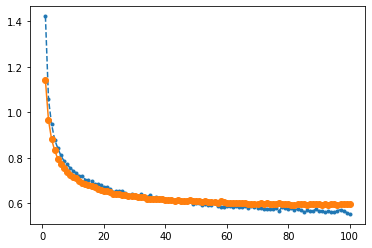

In [271]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [272]:
y_pred = model2.predict(x_yam_valid)
y_pred_class = np.argmax(y_pred,axis=1).astype(int)

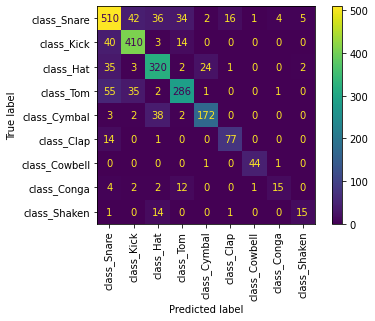

In [273]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_class, y_pred_class),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [274]:
print(classification_report(y_valid_class, y_pred_class, target_names=classes_cols))

               precision    recall  f1-score   support

  class_Snare       0.77      0.78      0.78       650
   class_Kick       0.83      0.88      0.85       467
    class_Hat       0.77      0.83      0.80       387
    class_Tom       0.82      0.75      0.78       380
 class_Cymbal       0.86      0.79      0.82       217
   class_Clap       0.81      0.84      0.82        92
class_Cowbell       0.96      0.96      0.96        46
  class_Conga       0.71      0.42      0.53        36
 class_Shaken       0.68      0.48      0.57        31

     accuracy                           0.80      2306
    macro avg       0.80      0.75      0.77      2306
 weighted avg       0.80      0.80      0.80      2306



In [275]:
roc_auc_score(y_valid_class, model2.predict(x_yam_valid), average='weighted', multi_class='ovr')

0.96048063064831

In [276]:
model.trainable = False
inputs = model.inputs
x = model.get_layer(index=-3).output
outputs = Dense(1, activation='sigmoid')(x)
model3 = Model(inputs, outputs)
model3.summary()
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
total = len(y_train['class_Shaken'])
positive = (y_train['class_Shaken'] == 1).sum()
negative = (y_train['class_Shaken'] == 0).sum()
weights = {0:(1 / negative)*(total)/2.0 ,1:(1 / positive)*(total)/2.0}
history = model3.fit(x_vgg_train, y_train['class_Shaken'], epochs=100, class_weight=weights, validation_data=(x_vgg_valid, y_valid['class_Shaken']))

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_57 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_31 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 51        
Total params: 18,001
Trainable params: 51
Non-trainable params: 17,950
_________________________________________________________________
Epoch 1/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5842 - accuracy: 0.6577 - val_loss: 0

Epoch 51/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0406 - accuracy: 0.9786 - val_loss: 0.0965 - val_accuracy: 0.9714
Epoch 52/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0467 - accuracy: 0.9799 - val_loss: 0.0977 - val_accuracy: 0.9714
Epoch 53/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0376 - accuracy: 0.9795 - val_loss: 0.0959 - val_accuracy: 0.9718
Epoch 54/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0404 - accuracy: 0.9781 - val_loss: 0.0915 - val_accuracy: 0.9727
Epoch 55/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0449 - accuracy: 0.9812 - val_loss: 0.0960 - val_accuracy: 0.9718
Epoch 56/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0529 - accuracy: 0.9775 - val_loss: 0.1023 - val_accuracy: 0.9709
Epoch 57/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0415 - accuracy: 0.9751 - val_loss: 0.0982 - val_accuracy:

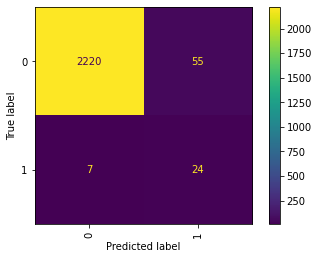

In [277]:
y_pred = model3.predict(x_vgg_valid)
y_pred_class = (y_pred > 0.5).astype(int)
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid['class_Shaken'], y_pred_class),
)
conf_matrix.plot(xticks_rotation=90);

In [278]:
print(classification_report(y_valid['class_Shaken'], y_pred_class))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2275
         1.0       0.30      0.77      0.44        31

    accuracy                           0.97      2306
   macro avg       0.65      0.88      0.71      2306
weighted avg       0.99      0.97      0.98      2306



0.9654165189649061


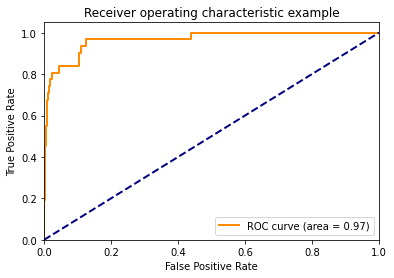

In [279]:
fpr, tpr, _ = roc_curve(y_valid['class_Shaken'], model3.predict(x_vgg_valid))
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()